### Todo:

##### Task 1:

Represent atleast one cause of missing MapMatching samples


##### Task 2:

Check how driver drives at different times spans of the day. Make comparisons between different days during same hours. This will tell us if the time of the day makes a difference in the avg. driving speed(kph) i.e how time of the day effects the driving speed.


##### Task 3:

Calculate additional features from the given features. ( TimeDiff & RoadLength )

##### Task 4:

Try to predict the missing MapMatching values

Steps:

1) Convert timestamp to unix timestamp

2) train the model on the timediff, speed, roadlength  and data providers as features.


<font color='red'>Note: All the text written in green color represents the observations. The observations are written after the charts are drawn in the preceding cells.</font>

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from pandas.plotting import scatter_matrix
import datashader as ds
from numpy.random import random
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
from bokeh.layouts import gridplot
import datashader.transfer_functions as tf
from bokeh.io.export import get_screenshot_as_png
import scipy.special
from sklearn.metrics import accuracy_score
%matplotlib inline
output_notebook()

Loading BokehJS ...

In [2]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y.%m.%d_%H:%M:%S')
df = pd.read_csv("./example3.csv", parse_dates=[0], header=None, date_parser=dateparse, index_col=0)
df

,1,2,3
0,,,
2017-11-15 17:19:56,30.25,10,0
2017-11-15 17:17:13,7.66,--,1
2017-11-15 17:15:27,32.75,--,2
2017-11-15 17:15:21,38.25,14,3
2017-11-15 17:13:52,29.38,--,1
2017-11-15 17:13:31,38.75,--,1
2017-11-15 17:11:55,23.75,--,1
2017-11-15 17:11:46,39.75,--,1
2017-11-15 17:10:30,13.88,--,1


## Task 1 (Solution):

Finding the worst provider with maximum -- values in the dataset.

<font color='green'>We come to conclude that the worst provider is provider 1</font> 

Now we'll try to figure out atleast one reason, why ?

In [200]:
df_no_dash = df.replace('--',np.NaN)
df_no_dash = df_no_dash[df_no_dash[2].isnull()].groupby(3)[1].count().reset_index()
df_no_dash

,3,1
0,1,191518
1,2,121152
2,3,1303
3,4,79506
4,5,27622
5,6,46855
6,7,1234
7,8,13470
8,9,671
9,10,148


##### Next the idea is to scatter plot the average speed with respect to time to find out patterns that helps us identify why the MapM values are missing in our data.

In [19]:
def get_separated_mapm(df_start):    
    df_prov_1 = df_start[df_start[3] == 1]
    df_prov_1 = df_prov_1.rename(index=str, columns={1:"Speed", 2:"MapM", 3:"Provider"})
#     df_prov_1.index = pd.to_datetime(df_prov_1.index)
#     df_prov_1.index = [t.value // 10 ** 9 for t in df_prov_1.index]
    df_prov_1.loc[:,'Time'] = df_prov_1.index
    df_prov_1 = df_prov_1.replace('--',np.NaN)

    df_with_dash = df_prov_1[df_prov_1['MapM'].isnull()]
    df_without_dash = df_prov_1.dropna()
    
    return df_with_dash, df_without_dash


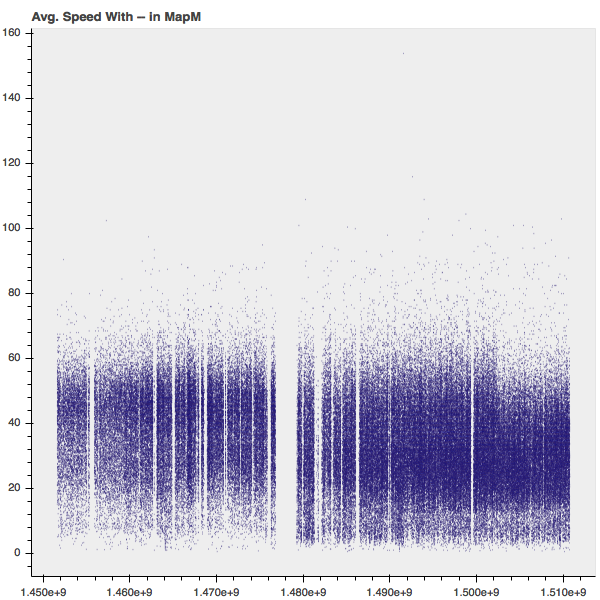

In [10]:
def mscatter(p, x, y, marker):
    p.scatter(x, y, marker=marker, size=0.5,
              line_color="navy", fill_color="orange", alpha=0.5)


df_with_dash, df_without_dash = get_separated_mapm(df)
p = figure(title="Avg. Speed With -- in MapM", toolbar_location=None)
p2 = figure(title="Avg. Speed Without -- in MapM", toolbar_location=None)

p.grid.grid_line_color = None
p.background_fill_color = "#eeeeee"
p2.grid.grid_line_color = None
p2.background_fill_color = "#eeeeee"

mscatter(p, df_with_dash.loc[:,'Time'].values, df_with_dash.loc[:,'Speed'].values, "circle")
mscatter(p2, df_without_dash.loc[:,'Time'].values, df_without_dash.loc[:,'Speed'].values, "circle")

# show(p)
# show(p2)
get_screenshot_as_png(p, driver=None)


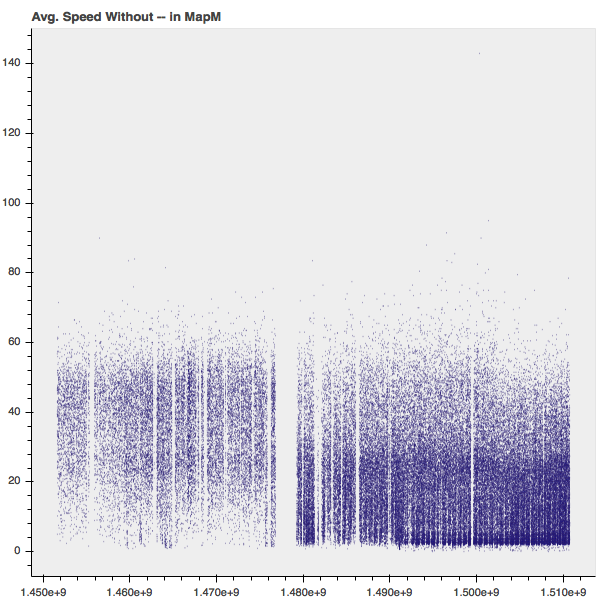

In [11]:
get_screenshot_as_png(p2, driver=None)

<font color='green'>The range of speed for both the plots(above) with and without '--' values is somewhat similar but we do identify in the second plot that the points distribution is more dense in the later times compared to the previous times. One idea to further visualize it will be to identify how the difference in time between readings is effecting the MapM values.</font>

In [15]:
def calculate_time_diff(time_df):
    df2 = pd.DataFrame(time_df.index)
#     time_df.index = [t.value // 10 ** 9 for t in time_df.index]
    df2[0] = df2.diff(periods=-1)
    df2.index = time_df.index
    df3 = pd.merge(df2,time_df,on=df2.index)
    return df3


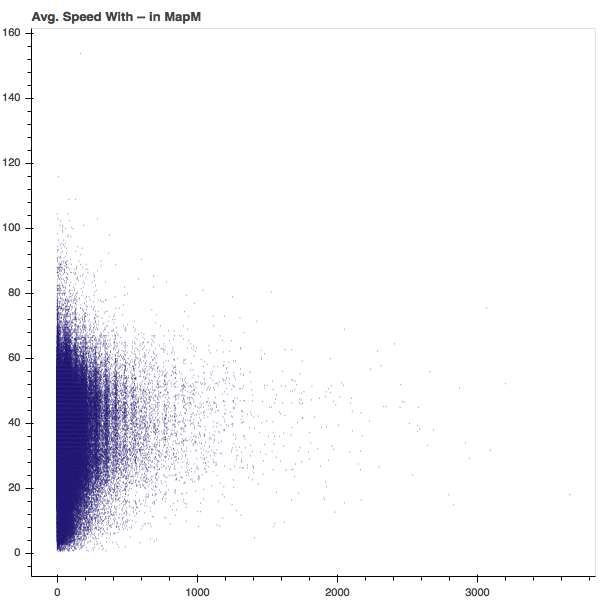

In [20]:
df3 = calculate_time_diff(df)
df_with_dash, df_without_dash = get_separated_mapm(df3)
df_with_dash2 = df_with_dash.rename(index=str, columns={"key_0": "Timestamp", 0: "TimeDiff", 1:"Speed", 2:"MapM", 3:"Provider"})
df_without_dash2 = df_without_dash.rename(index=str, columns={"key_0": "Timestamp", 0: "TimeDiff", 1:"Speed", 2:"MapM", 3:"Provider"})

p3 = figure(title="Avg. Speed With -- in MapM", toolbar_location=None)
p4 = figure(title="Avg. Speed Without -- in MapM", toolbar_location=None)

p3.grid.grid_line_color = None
p4.background_fill_color = "#eeffff"
p3.grid.grid_line_color = None
p4.background_fill_color = "#eeeeee"

mscatter(p3, df_with_dash2.loc[:,'TimeDiff'].values, df_with_dash2.loc[:,'Speed'].values, "circle")
mscatter(p4, df_without_dash2.loc[:,'TimeDiff'].values, df_without_dash2.loc[:,'Speed'].values, "circle")

# show(p3)
# show(p4)
get_screenshot_as_png(p3, driver=None)

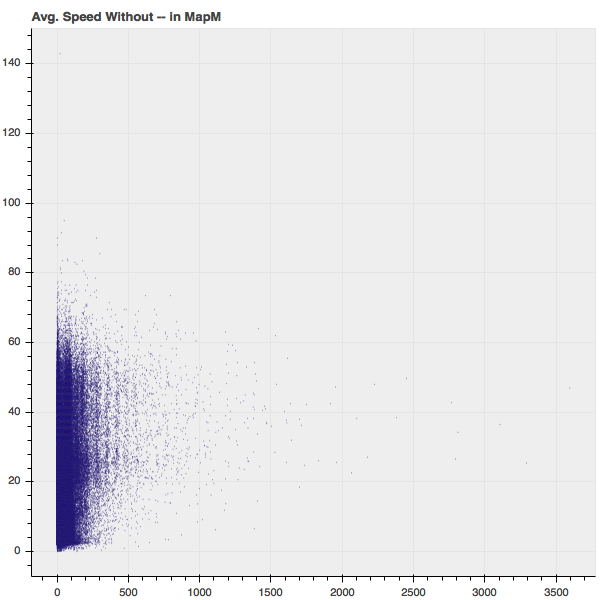

In [22]:
get_screenshot_as_png(p4, driver=None)

<font color='green'>If we take a look at the resulting plots above. We can see that for the first scatter plot most of the values have a large time difference between the previous and the next reading. Ofcourse this is not the only factor that is playing it's part in the reading not being able to detected properly but this is one major factor. While for the second plot, it can be clearly observed that most of the values have a smaller time difference. 
    
<b>Note:</b> The x-axis represent the time difference between the last reading and the next reading. And y-axis represent the speed of the data. The first plot represents all the samples where we have MapM values while the second represents the samples without MapM values.
</font>

## Task 2 (Solution)


###### divided each day into 4 quaters. 
- q1 = 00:00 to 06:00
- q2 = 06:00 to 12:00
- q3 = 12:00 to 18:00
- q4 = 18:00 to 23:00

###### And than, visualized the distribution of  speed values among different times of the day.

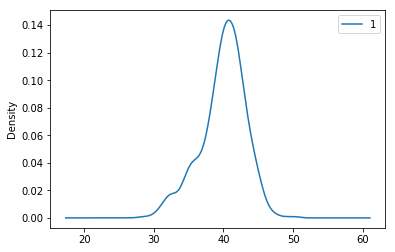

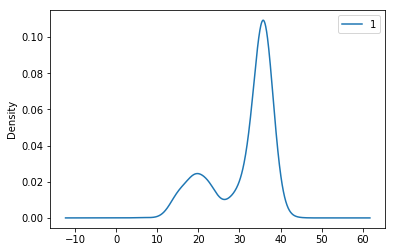

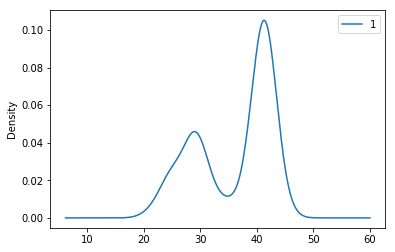

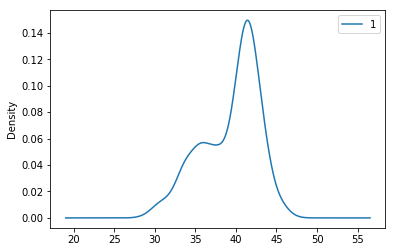

In [3]:
groupedday_hr = df.groupby([df.index.date,df.index.hour])[1].mean()
result = groupedday_hr.reset_index(level=0)

result[2] = np.where((result[0] >= 0) & (result[0] < 6),'q1','q2')
result.loc[(result[0]>=12) & (result[0]<18),2] = 'q3'
result.loc[(result[0]>=18) & (result[0]<24),2] = 'q4'

## now we group w.r.t dates and quartes and find out how drivers drove every day on those specific quarters.
quarters_avg_speed = result.groupby([result.index,result[2]])[1].mean().reset_index(level=1)
quarters_avg_speed.loc[quarters_avg_speed[2] == 'q1'].plot.kde()
quarters_avg_speed.loc[quarters_avg_speed[2] == 'q2'].plot.kde()
quarters_avg_speed.loc[quarters_avg_speed[2] == 'q3'].plot.kde()

quarters_avg_speed.loc[quarters_avg_speed[2] == 'q4'].plot.kde()

<font color='green'>

The plot of q1 suggests most of the people are driving slightly above 40km/h. This is the only quarter where most of the drivers prefer to go around 40km/h or more (on average) while for the other quarters(q2,q3,q4) it can be observed that there are two spikes in the graphs. This can be due to the fact that the other quarters represent more busy parts of the day where drivers can be caused to slow down.</font>

## Task 3 (Solution)


In [21]:
# step (1)
df3 = calculate_time_diff(df)
df3 = df3.rename(index=str, columns={"key_0": "Timestamp", 0: "TimeDiff", 1:"Speed", 2:"MapM", 3:"Provider"})
df3

,Timestamp,TimeDiff,Speed,MapM,Provider
0,1510766396,163.0,30.25,10,0
1,1510766233,106.0,7.66,--,1
2,1510766127,6.0,32.75,--,2
3,1510766121,89.0,38.25,14,3
4,1510766032,21.0,29.38,--,1
5,1510766011,96.0,38.75,--,1
6,1510765915,9.0,23.75,--,1
7,1510765906,76.0,39.75,--,1
8,1510765830,6.0,13.88,--,1
9,1510765824,170.0,8.25,16,1


<font color='green'>

We calculate additional feature i.e the <b>time difference</b> from the last reading to the current reading. This additional feature will be a good use to find patterns in data to train a machine learning model for prediction of MapMatching values. This will also ensure a feature with values repeating in a certain range whereas the timestamp contains unique values for each sample which doesn't tells us much.
</font>


In [22]:
# step (3.1) - first take the records on for which you have MapM value
df4 = df3.replace('--',np.NaN)
df4['MapM'] = df4['MapM'].apply(pd.to_numeric)

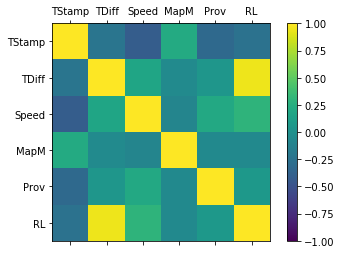

In [23]:
df4 = df4.dropna()
df4['RoadLength'] = df4['TimeDiff'] * df4['Speed']
correlations = df4.corr()
names = ['TStamp','TDiff','Speed', 'MapM','Prov','RL']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,6,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

##### Visualizing the correlation matrix plot of found features in a plot
<font color='green'>
We're just visualizing above how different features in the data are correlated to each other. 

Additioanlly,We are calculating a feature called <b>Road Length</b> using a simple speed=distance/time formula to estimate the length of road using the average given speed and the timedifference we calculated previously between the previous and the current reading. 
</font>

## Task 4 (Solution)
<font color='green'>
    
We use RandomForest to estimate the missing MapM values in our data. Different values of n_estimators are tried and the best one is shown here.</font>

In [26]:
def get_features_labels(data):
    train_features = data.drop(['MapM','Timestamp'],axis=1)
    train_label = data['MapM']
    return train_features, train_label

train, test = train_test_split(df4, test_size=0.1)
train_features, train_label = get_features_labels(train)

rf = RandomForestRegressor(n_estimators = 50, random_state = 42)

# Train the model on training data
rf.fit(train_features, train_label);

#### Prediction Loss (MSE) :

<font color='green'>Find the mean squared error for the above trained RandomForest algorithm</font>

In [49]:
test_features, test_label = get_features_labels(test)

predictions = rf.predict(test_features)

squared_error = mean_squared_error(predictions,test_label.values)
# squared_error

result = pd.DataFrame(test_label.values)
result[1] = pd.DataFrame(predictions)
result = result.rename(index=str, columns={0: "Labels", 1: "Predictions"})
result

,Labels,Predictions
0,-2.0,4.301500
1,2.0,-2.903333
2,14.0,-5.603333
3,8.0,2.972000
4,-7.0,-2.316833
5,-10.0,-3.169493
6,-5.0,0.528327
7,9.0,-3.498333
8,0.0,-2.258000
9,-3.0,-2.341501


In [47]:
squared_error

64.99576679649277